# Raport
### Skład grupy
Miłosz Chrzempie 148059
### Zastosowany model sinogramu
Został zastosowany model stozkowy
### Zastosowany jezyk programowania
Jupyter notebook z Pythonem, biblioteki numpy i kilka funkcji z scipy

# Utility functions
Generacja kernelu do filtracji

In [1]:
import math

def is_odd(num: int):
    return num % 2 != 0

def get_kernel(elements: int):
    kernel = []
    for k in range(elements):
        i = k - math.floor(elements / 2)
        if is_odd(k):
            x = (-4 / (math.pi ** 2)) / (i ** 2)
            kernel.append(x)
        else:
            kernel.append(0)
    kernel[math.floor(elements / 2)] = 1
    return kernel

kernel = get_kernel(21)

# Załadowanie zdjęcia
Załadowanie zdjęcia i powiększenia canvasu aby całość zdjęcia podlegała transformacji Radona

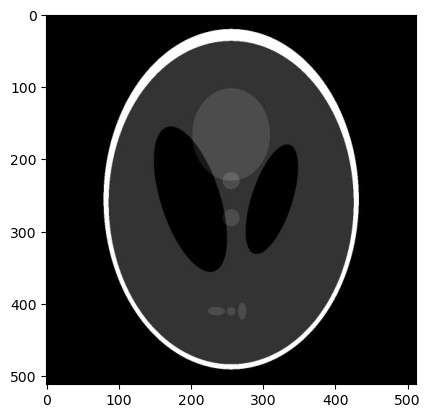

In [56]:
from matplotlib import image
from matplotlib import pyplot as plt
from skimage.draw import line_nd
import numpy as np

raw = np.average(np.array(image.imread('images/Shepp_logan_small.jpg')), axis=2)
size = np.max(raw.shape) * 2
data = np.zeros([size, size])

center_x, center_y = np.array(data.shape) // 2

top_left_x = center_x - raw.shape[0] // 2
top_left_y = center_y - raw.shape[1] // 2

data[top_left_x:top_left_x + raw.shape[0], top_left_y:top_left_y + raw.shape[1]] = raw

plt.imshow(raw, cmap="gray")

# Parametry transformacji Radona

In [41]:
import ipywidgets as widgets

# create widgets for three numbers and a checkbox
input_scans = widgets.FloatSlider(value=180, min=90, max=720, step=90, description='Step')
input_detectors = widgets.FloatSlider(value=180, min=90, max=720, step=90, description='Detectors')
input_fi = widgets.FloatSlider(value=180, min=45, max=270, step=45, description='Range')
use_filtering = widgets.Checkbox(value=False, description='Use filtering')

# display the widgets using a VBox layout
widgets.VBox([input_scans, input_detectors, input_fi, use_filtering])

# Generowanie sinogramu
w modelu stozkowym

In [4]:
# generowanie punktu na podstawie kąta
def circle_point(radians: float):
    x = math.sin(radians)   
    y = math.cos(radians)
    return np.array([x, y])

# generowanie puktów końcowych w modelu stozkowym
def end_points(alpha: float, detectors, fi):
    points = np.array([])
    for i in range(detectors):
        x = math.sin(alpha + math.pi - (fi/2) + (i * (fi/(detectors-1))))
        y = math.cos(alpha + math.pi - (fi/2) + (i * (fi/(detectors-1))))
        points = np.array([*points, np.array([x, y])])
    return points

# generowanie sinogramu na podstawie parametrów
def generate_sinogram(step_angle, detectors, fi, filtering):
    # pojedynczy promien transformaty Radona
    def ray(data, start, stop):
        line = line_nd(start, stop)
        ray = data[line]
        return np.average(ray)

    angles = np.linspace(0, np.radians(360), num=math.floor(np.radians(360) // step_angle), endpoint=False)

    sinogram = []
    # dla kazdego kata wejsciowego
    for angle in angles:
        slice = np.array([])
        start = circle_point(angle) * (size/2) + (size/2 - 1)
        # dla kazdego endpointu
        for end_point in end_points(angle, detectors, fi):
            stop = end_point * (size/2) + (size/2 - 1)
            z = ray(data, start, stop)
            slice = np.append(slice, z)
        if filtering:
            slice = np.convolve(slice, kernel, mode='same')
        sinogram.append(slice)
    return sinogram

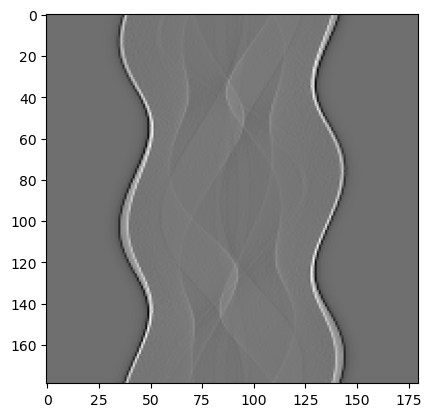

In [60]:
# generowanie sinogramu z podanego zdjęcia
sinogram = generate_sinogram(np.radians(360) / input_scans.value, int(input_detectors.value), np.radians(input_fi.value), use_filtering.value)
plt.imshow(sinogram, cmap="gray")

# Odwrotna transformacja Radona

In [6]:
step_angle = np.radians(360) / input_scans.value
detectors = int(input_detectors.value)
fi = np.radians(input_fi.value)

def reverse(sinogram, step_angle, detectors, fi):
    # Określenie kątów, dla których wykonano skany
    angles = np.linspace(0, np.radians(360), num=math.floor(np.radians(360) // step_angle), endpoint=False)

    # Stworzenie listy reprezentującej obraz, zaczynając od czarnej planszy
    inverse = [np.zeros(data.shape)]

    # Dla każdego kąta wykonania skanu
    for (j, angle) in enumerate(angles):
        current = np.copy(inverse[-1])
        start = circle_point(angle) * (size/2) + (size/2 - 1)
        # Dla każdego detektora na linii skanującej
        for (i, end_point) in enumerate(end_points(angle, detectors, fi)):
            stop = end_point * (size/2) + (size/2 - 1)
            out = line_nd(start, stop)
            # Dodanie sumy jasności pikseli linii do obrazu wynikowego
            current[out] += sinogram[j][i]
        # Dodanie otrzymanego obrazu do listy wynikowej
        inverse = [*inverse, current]

    # Stworzenie listy reprezentującej wynikowe obrazy po znormalizowaniu
    final = []
    for i in inverse:
        center_x, center_y = np.array(data.shape) // 2
        original_size = size // 2
        center = i[center_x - original_size//2:center_x + original_size//2, center_y - original_size//2:center_y + original_size//2]
        final.append(center)
        
    # Normalizacja obrazów do wartości 0-255
    normalized = ((final - np.min(final)) / (np.max(final) - np.min(final))) * 255

    return normalized

In [61]:
# generowanie odtworzonego obrazu na podstawie sinogramu ze zdjecia
from ipywidgets import interact, widgets

output = reverse(sinogram, np.radians(360) / input_scans.value, int(input_detectors.value), np.radians(input_fi.value))

# Prezentacja wyników

In [62]:
def show(iteration: int):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    mse = np.mean((raw - output[iteration]) ** 2) / 255
    rmse = np.sqrt(mse)

    axs[0].imshow(raw, cmap='gray')
    axs[1].imshow(sinogram, cmap='gray')
    axs[2].imshow(output[iteration], cmap='gray')

    axs[0].set_title('Original image')
    axs[1].set_title('Sinogram')
    axs[2].set_title('Reconstructed image (RMSE {:.2F})'.format(rmse))

interact(show, iteration=widgets.IntSlider(min=0, max=int(input_scans.value) - 1, step=1, value=int(input_scans.value) - 1))

interactive(children=(IntSlider(value=179, description='iteration', max=179), Output()), _dom_classes=('widget…

<function __main__.show(iteration: int)>

In [ ]:
# funkcja pomocnicza zwracająca obraz po transformacie radona na podstawie zdjecia
def radon(scans, detectors, fi, filtering):
    sinogram = generate_sinogram(np.radians(360) / scans, int(detectors), np.radians(fi), filtering)
    output = reverse(sinogram, np.radians(360) / scans, int(detectors), np.radians(fi))
    return output

# DICOM
Odczyt i zapis obrazu w standardzie DICOM

In [63]:
import pydicom
from pydicom.dataset import Dataset
from datetime import datetime
import ipywidgets as widgets

name_widget = widgets.Text(description='Patient Name:')
age_widget = widgets.IntSlider(description='Patient Age:', min=0, max=100)
sex_widget = widgets.RadioButtons(options=['M', 'F'], description='Patient Sex:')
comment_widget = widgets.Textarea(description='Comment:', rows=5)

button = widgets.Button(description='Save DICOM')

def save_dicom(button):
    ds = Dataset()
    ds.PatientName = name_widget.value
    ds.PatientID = "123"
    ds.PatientAge = str(age_widget.value)
    ds.PatientSex = sex_widget.value
    ds.SOPClassUID = "1.2.840.10008.5.1.4.1.1.7"
    ds.SOPInstanceUID = pydicom.uid.generate_uid()

    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.StudyDate = datetime.now().strftime('%Y%m%d')
    ds.StudyTime = datetime.now().strftime('%H%M%S')
    ds.StudyDescription = "Example study"

    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesNumber = 1
    ds.Modality = "CT"
    ds.SeriesDescription = "Series"

    img = np.round(output[-1]).astype("uint8")
    pixel_data = img.tobytes()

    ds.Rows, ds.Columns = img.shape
    ds.PixelSpacing = [1, 1]
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0 
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.is_little_endian = False
    ds.is_implicit_VR = False

    ds.PixelData = pixel_data

    ds.ImageComments = comment_widget.value

    pydicom.filewriter.write_file("image.dcm", ds, write_like_original=False)

button.on_click(save_dicom)
input_widgets = widgets.VBox([name_widget, age_widget, sex_widget, comment_widget])
display(widgets.VBox([input_widgets, button]))

/Users/miloszchrzempiec/anaconda3/lib/python3.10/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR AS: '20'.
  warnings.warn(msg)


# Benchmark

Liczba detektorów zmienia się od 90 do 720 z krokiem 90,


In [ ]:
tests = []

for s in range(90, 721, 90):
    test = radon(s, 180, 180, False)
    tests.append((s, test[-1]))

In [ ]:
fig, axs = plt.subplots(1, len(tests), figsize=(20, 8))

for (i, t) in enumerate(tests):
    s, test = t
    axs[i].imshow(test, cmap='gray')
    mse = np.mean((raw - test) ** 2) / 255
    rmse = np.sqrt(mse)
    axs[i].set_title(str(s) + ' (RMSE {:.2F})'.format(rmse))